In [30]:
import torch
import torch.nn as nn
from torch.nn import functional as F

torch.manual_seed(1337)

In [3]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [4]:
print(len(text))

1115394


In [5]:
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [6]:
chars = sorted(list(set(text))) # all the unique chars in this text
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [7]:
# Tokenization 
# We simply create a mapping from char to int 
stoi = { ch:i for i,ch in enumerate(chars)}
itos = { i:ch for i,ch in enumerate(chars)}

# Then, a way to encode and decode our chars/words/sentences
encode = lambda s: [stoi[ch] for ch in s] # takes a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # takes a list of integers, output a string

print(encode("hello world !"))
print(decode(encode("hello world !")))

[46, 43, 50, 50, 53, 1, 61, 53, 56, 50, 42, 1, 2]
hello world !


In [12]:
# let's now tokenize the whole dataset
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:10])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47])


In [15]:
# Train/Test split

n = int(0.9*len(data))
train_data = data[:n]
test_data = data[n:]

len(train_data), len(test_data)

(1003854, 111540)

In [16]:
block_size = 8 # context window of chars
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [ ]:
# Slowly creating/understanding our training dataset
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"input {context} target: {target}")

# we wan't the model to learn to generate from one char all the way to block_size chars

input tensor([18]) target: 47
input tensor([18, 47]) target: 56
input tensor([18, 47, 56]) target: 57
input tensor([18, 47, 56, 57]) target: 58
input tensor([18, 47, 56, 57, 58]) target: 1
input tensor([18, 47, 56, 57, 58,  1]) target: 15
input tensor([18, 47, 56, 57, 58,  1, 15]) target: 47
input tensor([18, 47, 56, 57, 58,  1, 15, 47]) target: 58


In [ ]:
# let's create the batches 

batch_size = 4 # number of independant sequences processed in parallel
block_size = 8 # maximum context length for prediction

def get_batch(split):
    if split == 'train':
        data = train_data
    else:
        data = test_data
    
    ix = torch.randint(len(data) - block_size, (batch_size,)) # get batch_size random idx in the dataset
    x = torch.stack([data[i:i+block_size] for i in ix]) # for each ix, we get the block starting at this window and we stack them all
    y = torch.stack([data[i+1:i+block_size+1] for i in ix]) # getting the targets by shifting the window by one
    return x,y

xb, yb = get_batch("train")
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('--------')

for b in range(batch_size):
    for t in range(block_size):
        context = xb[b, :t+1]
        target = yb[b, t]
        print(f'input {context.tolist()} target: {target}')

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
--------
input [24] target: 43
input [24, 43] target: 58
input [24, 43, 58] target: 5
input [24, 43, 58, 5] target: 57
input [24, 43, 58, 5, 57] target: 1
input [24, 43, 58, 5, 57, 1] target: 46
input [24, 43, 58, 5, 57, 1, 46] target: 43
input [24, 43, 58, 5, 57, 1, 46, 43] target: 39
input [44] target: 53
input [44, 53] target: 56
input [44, 53, 56] target: 1
input [44, 53, 56, 1] target: 58
input [44, 53, 56, 1, 58] target: 46
input [44, 53, 56, 1, 58, 46] target: 39
input [44, 53, 56, 1, 58, 46, 39] target: 58
input [44, 53, 56, 1, 58, 46, 39, 58] target: 1
input [52] target: 58
input [52, 58] ta

In [ ]:
# Before implementing a transformer, we start with a bigram model

# Note : 
# B --> batch, T --> time, C --> channel
# time is for the context (words come sequentially)
# channel is the embedding dim (vocab_size here)
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size) 

    def forward(self, idx, targets=None):
        #idx and targets are both (B,T) tensor of ints
        logits = self.token_embedding_table(idx) #(B,T,C)

        if targets is None:
            loss = None
        else:
            # PB : the cross entropy loss wan'ts a (B,C,T)
            # Fix : we reshape the logits
            B,T,C = logits.shape # unpacking the shape
            logits = logits.view(B*T,C)
            targets = targets.view(B*T) # it must only be a 1D vector
            loss = F.cross_entropy(logits, targets)
        return logits, loss 
    
    def generate(self, idx, max_new_tokens):
        # for now this generate fct is overkill 
        # We are feeding it with all the context but it's useless as its a bigram model 
        # Still, we implement it like this so that it will be unchanged for transformers

        # idx is (B,T) array of indices in the current context
        for _ in range(max_new_tokens):
            logits, loss = self(idx) # get the preds
            # focus only on the last time step (i.e last char)
            logits = logits[:, -1, :] # becomes (B,C) bc it's only one embedded char for each sequence in the batch
            probs = F.softmax(logits, dim=1) # (B,C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B,1) choose one for each sequence in the batch
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx
    
m = BigramLanguageModel(vocab_size)
out, loss = m(xb, yb)
print(out.shape) # (B,T,C) = (batch_size, block_size, vocab_size)
print(loss)

torch.Size([32, 65])
tensor(4.6596, grad_fn=<NllLossBackward0>)


In [ ]:
# visualize the reshape of logits and targets : 
# making sure the dimensions are right 
print(xb.shape) # (B,T) = (4,8)
logits = m.token_embedding_table(xb) # (B,T,C) = (4,8,65)
B,T,C = logits.shape
print(B,T,C)
print(logits.view(B*T,C).shape) # (BT, C) = (32,65)

# from a list of matrices of embedded char sequences
# to a matrice of embedded char sequences 
# i.e we concatenate 
print(logits[1][0]) # second matrice, first embedding
print(logits.view(B*T,C)[8]) # embedding on row 9 i.e same  
# it's really a concatenation or stacking of the batches so that we can use the cross entropy loss


torch.Size([4, 8])
4 8 65
torch.Size([32, 65])
tensor([-1.1407,  0.1674,  3.2928,  0.0336,  0.7214, -0.1166,  0.1251,  0.8942,
        -0.2180, -0.1490, -0.4618, -1.3175,  0.2292, -0.0070, -0.4757, -0.7134,
         0.4785, -1.2345, -1.1819, -0.9485,  0.9860,  0.2522,  1.0774, -0.1448,
         1.1254,  1.5455, -1.6235, -0.6772, -1.5064,  1.0463, -0.4910, -0.4300,
        -1.1951, -1.1122,  0.3443,  0.8044, -0.8518, -0.0058,  0.1490,  0.1472,
        -1.0353, -0.3813,  0.6480,  0.5152,  0.2458, -1.1127,  0.0113, -2.0395,
         0.7252,  0.1996,  0.1466,  1.9144, -0.5803,  0.2800,  0.1617,  2.4106,
         0.9564, -1.8647, -0.6692, -0.5670, -0.2337, -0.4600,  1.3712,  0.7031,
        -1.1733], grad_fn=<SelectBackward0>)
tensor([-1.1407,  0.1674,  3.2928,  0.0336,  0.7214, -0.1166,  0.1251,  0.8942,
        -0.2180, -0.1490, -0.4618, -1.3175,  0.2292, -0.0070, -0.4757, -0.7134,
         0.4785, -1.2345, -1.1819, -0.9485,  0.9860,  0.2522,  1.0774, -0.1448,
         1.1254,  1.5455, -1

In [ ]:
-torch.log(torch.tensor(1/vocab_size)) # cross entropy if the prior is uniform (as it should be)
# It's lower than the current loss so it's not good
# we can resolve that by initalizing proprely but we won't do it here as it's just a baseline model

tensor(4.1744)

In [ ]:
# Let's generate from the model 
idx = torch.zeros((1,1), dtype=torch.long) # just a zero tensor 
# zero represents a newline char in our dict so it's coherent to use it as a first char

generated_idx = m.generate(idx, max_new_tokens=100)[0].tolist() # [0] because we access the "single batch"
print(decode(generated_idx))


TlXrvCAqOA!JKmHxETa-:S;GbQdPFw-VY:DrKm:,aJ$sCDrXEo.vef,R
QIV:kB'wrwGz-TmdKJP,jlRO,h;zK
,IwSUMhdWNenE


In [126]:
m.generate(idx, max_new_tokens=100).shape

torch.Size([1, 101])

In [131]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [130]:
print(m.parameters)

<bound method Module.parameters of BigramLanguageModel(
  (token_embedding_table): Embedding(65, 65)
)>


In [137]:
# training loop 
batch_size = 32

for steps in range(10000):
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())

2.4795644283294678


In [ ]:
# let's see how much we improved
idx = torch.zeros((1,1), dtype=torch.long) 
print(decode(m.generate(idx, max_new_tokens=300)[0].tolist()))
# It's way better that above (at initialization)
# But its still terrible


Hotod an youchatre:
Theean ourmatis t s:
WAR:
Sofe I isesealas f rdsthe aly thoumeit wamands at umbenererdepras thepr'do d,
Thinjeere rnie p me!

A:
BUS:
Anere; ifitithedson abeure I alew?
s th.

Louledr, todin de hit BANodden?
KER:

HAsead KEl s st t I iteen h te-memule idongrcoatay se:
CUTe'lld mm


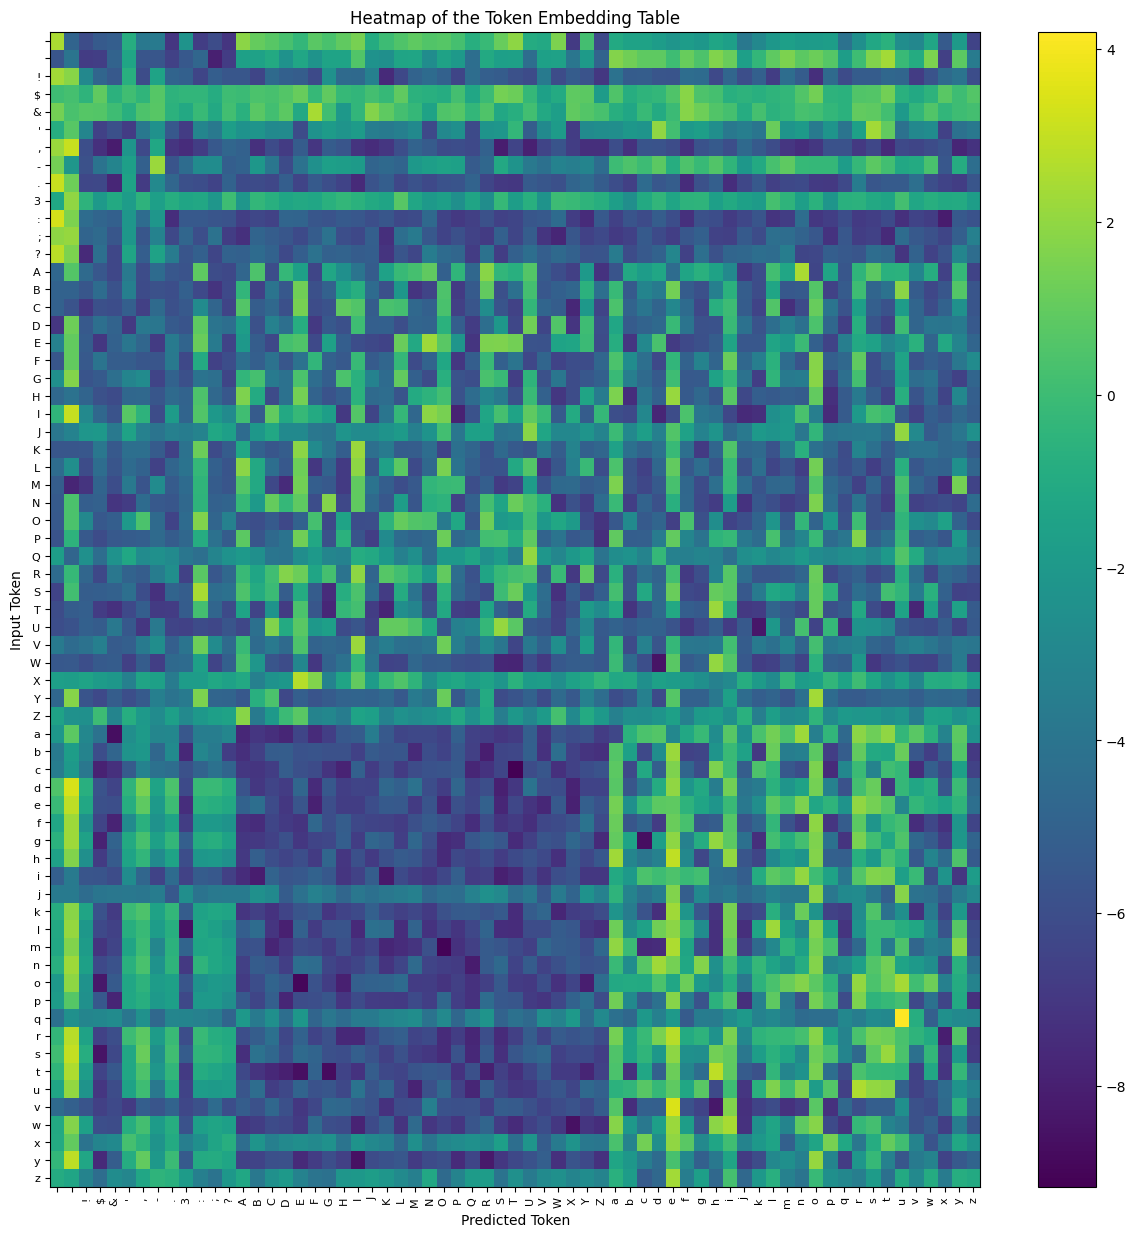

In [145]:
import numpy as np

import matplotlib.pyplot as plt

# Get the weight matrix from our embedding table
weights = m.token_embedding_table.weight.detach().cpu().numpy()

plt.figure(figsize=(15, 15))
plt.imshow(weights, cmap='viridis', aspect='auto')
plt.colorbar()

# Label rows and columns using itos (index-to-char mapping)
plt.xticks(ticks=np.arange(vocab_size), labels=[itos[i] for i in range(vocab_size)], rotation=90, fontsize=8)
plt.yticks(ticks=np.arange(vocab_size), labels=[itos[i] for i in range(vocab_size)], fontsize=8)

plt.xlabel("Predicted Token")
plt.ylabel("Input Token")
plt.title("Heatmap of the Token Embedding Table")
plt.show()

In [146]:
print(logits.shape)

torch.Size([256, 65])
